In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pCTRval = pd.read_csv('E:\\web_economics\\pCTRval.csv')
df_val = pd.read_csv('E:\\web_economics\\validation.csv')

## Bidding below Max eCPC -> Fajar

bid = maxEcpc * pCTR

In [12]:
adv = df_val.advertiser.unique()
table = pd.DataFrame(columns=['eCPC'])
ecpcs = []
for i in range(len(adv)):
    ad = adv[i]
    df = df_val[df_val.advertiser == ad]
    clicks = df.click.sum()
    costs = df.payprice.sum()
    ecpcs.append(costs / clicks)
table['eCPC'] = ecpcs
maxECPC = table['eCPC'].max()

In [13]:
def maxecpc_bid_generator():
    #bid = maxEcpc * pCTR
    bids = []
    for p in pCTRval['0']:
        bid = maxECPC * p
        bids.append(bid)

    return bids

In [14]:
ecpcs = pd.DataFrame()
ecpcs['bids'] = maxecpc_bid_generator()
df_val_temp = pd.concat([df_val, ecpcs],axis=1)
ecpcs

,bids
0,37.799027
1,1758.302668
2,198.347209
3,198.200852
4,107.780005
5,278.058745
6,143.525546
7,72.446871
8,26.369690
9,261.913165


In [27]:
data = pd.DataFrame(columns=['clicks','imps','spent','CTR','CPC','CPM'])
lists = {'clicks':[], 'imps':[], 'spent':[], 'ctr':[], 'cpc':[], 'cpm':[]}

budget = 6250000.0
imps = 0
clicks = 0
spent = 0
for i in range(0,len(df_val_temp)):
    payprice = df_val_temp.payprice[i]
    bid = df_val_temp.bids[i]
    if budget < payprice:
        break
    if bid >= payprice:
        imps = imps + 1
        clicks = clicks + df_val_temp.click[i]
        budget = budget - payprice
        spent = spent + payprice
ctr = ((clicks / imps) * 100).round(4).astype(str)
cpm = ((spent / imps) * 1000).round(4).astype(str)
cpc = (spent / clicks).round(4).astype(str)
lists['clicks'].append(clicks)
lists['imps'].append(imps)
lists['spent'].append(spent)
lists['ctr'].append(ctr)
lists['cpc'].append(cpc)
lists['cpm'].append(cpm)

data.clicks = lists['clicks']
data.imps = lists['imps']
data.spent = lists['spent']
data.CTR = lists['ctr']
data.CPC = lists['cpc']
data.CPM = lists['cpm']
data

,clicks,imps,spent,CTR,CPC,CPM
0,121,115474,6249957,0.1048,51652.5372,54124.3657


## Step function bidding -> Fajar

if pctr / avgCTR >= 0.8, bid max value (300), else bid 0

In [35]:
data = pd.DataFrame(columns=['r','clicks','imps','spent','CTR','CPC','CPM'])
lists = {'r':[],'clicks':[], 'imps':[], 'spent':[], 'ctr':[], 'cpc':[], 'cpm':[]}

ratios = np.linspace(0.8,0.9,10)
avgCTR = df_val.click.sum() / df_val.bidid.count()

maxr = 0
maxv = -1
for ratio in ratios:
    budget = 6250000.0
    imps = 0
    clicks = 0
    spent = 0    
    for i in range(0,len(pCTRval)):
        r = pCTRval['0'][i] / avgCTR
        if r >= ratio:
            bid = 300
            if budget < payprice:
                break
            if bid >= payprice:
                imps = imps + 1
                clicks = clicks + df_val_temp.click[i]
                budget = budget - payprice
                spent = spent + payprice
    ctr = ((clicks / imps) * 100)
    cpm = ((spent / imps) * 1000)
    cpc = (spent / clicks)
    if clicks > maxv:
        maxr = ratio
        maxv = clicks
    lists['r'].append(ratio)
    lists['clicks'].append(clicks)
    lists['imps'].append(imps)
    lists['spent'].append(spent)
    lists['ctr'].append(ctr)
    lists['cpc'].append(cpc)
    lists['cpm'].append(cpm)

data.r = lists['r']
data.clicks = lists['clicks']
data.imps = lists['imps']
data.spent = lists['spent']
data.CTR = lists['ctr']
data.CPC = lists['cpc']
data.CPM = lists['cpm']
data.iloc[np.where(data.r == maxr)[0]]

,r,clicks,imps,spent,CTR,CPC,CPM
0,0.8,175,70467,845604,0.248343,4832.022857,12000.0


## ORTB bidding -> Fajar

formula = sqrt(c/lambda * pctr + c**2) - c

In [29]:
def ortb_bid_generator():
    #formula = sqrt(c/lambda pctr + c*2) - c
    c = 6
    lamda = 5e-07
    bids = []
    for p in pCTRval['0']:
        bid = np.sqrt((c/lamda * p) + c**2) - c 
        bids.append(bid)

    return bids

In [30]:
ortbs = pd.DataFrame()
ortbs['bids'] = ortb_bid_generator()
df_val_temp = pd.concat([df_val, ortbs],axis=1)
df_val_temp

,click,weekday,hour,bidid,logtype,userid,useragent,IP,region,city,...,slotvisibility,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag,bids
0,0,5,14,91c6a6b9e90c0f54d3230815a5a3e22e,1,u_Vhk7C5STO8TZ3s8,windows_ie,14.122.240.*,216,232,...,0,1,0,449a22cd91d9042eda3d3a1b89a22ea8,227,102,0f951a030abdaedd733ee8d114ce2944,3427,"10006,10063,10059,10111",37.953129
1,0,3,14,24b3621ad3b063b6c09c541781d534b3,1,u_DANDbCAksMy,android_safari,116.22.55.*,216,217,...,FirstView,Na,118,11908,277,118,null,2997,null,291.029970
2,0,1,13,6e7bce0a9ad42f479827d37bf9618a9d,1,u_VhkxPnKHPo1H3Vb,windows_ie,60.215.242.*,146,149,...,0,0,70,d01411218cc79bc49d2a4078c4093b76,241,77,b2e35064f3549d447edbbdfb1f707c8c,3427,null,93.922258
3,0,5,18,6873feca381b8293bf418ba8408a014c,1,u_Vh5zL3B83ln9Xbl,windows_chrome,27.193.87.*,146,148,...,0,0,70,c46090c887c257b61ab1fa11baee91d8,241,77,0f951a030abdaedd733ee8d114ce2944,3427,null,93.885519
4,0,5,14,7e6430333c552cf0b32bb21dc792d2df,1,u_VhKPOr5wOt9HQsj,windows_ie,183.228.214.*,275,275,...,2,0,5,ff5123fb9333ca095034c62fdaaf51aa,300,178,361e128affece850342293213691a043,3386,null,67.769223
5,0,1,16,903211f027ca70f611544f42b94db094,1,u_VhTTPRKdOIm2Q-C,windows_chrome,116.52.130.*,308,309,...,0,1,0,e1af08818a6cd6bbba118bb54a651961,238,49,a5d0bde104fea52ea466c77b37948424,3476,"10077,10075,10059,10052,10083,10031,10057,1000...",112.247756
6,0,3,18,15274113eac79b065e186c1962c33632,1,u_Vh5hL5mAOIuVemB,windows_ie,180.173.153.*,79,79,...,0,0,52,b90c12ed2bd7950c6027bf9c6937c48a,300,52,361e128affece850342293213691a043,3386,null,79.057507
7,0,2,0,9c963e762671efbc15c4e9fb3cef9c46,1,u_DAN0n0B6z9B,windows_ie,124.117.229.*,374,375,...,FirstView,Na,0,10717,294,86,null,2821,null,54.578065
8,0,0,7,a483f16043e9f0057d542ee724cd81cb,1,u_VhkrLAFj3cnslVk,windows_ie,14.108.1.*,275,275,...,0,0,50,e1af08818a6cd6bbba118bb54a651961,254,212,a5d0bde104fea52ea466c77b37948424,3476,"10063,10006,10059,10083,13403,10031,10110",30.859446
9,0,0,7,2da6d0891a81ac8233bba9bcffde2159,1,u_VhkSOxduLTmcjmL,windows_chrome,60.171.29.*,106,110,...,2,0,5,48f2e9ba15708c0146bda5e1dd653caa,300,40,bebefa5efe83beee17a3d245e7c5085b,1458,"10031,13042,10006,10110",108.772477


In [31]:
data = pd.DataFrame(columns=['clicks','imps','spent','CTR','CPC','CPM'])
lists = {'clicks':[], 'imps':[], 'spent':[], 'ctr':[], 'cpc':[], 'cpm':[]}

budget = 6250000.0
imps = 0
clicks = 0
spent = 0
for i in range(0,len(df_val_temp)):
    payprice = df_val_temp.payprice[i]
    bid = df_val_temp.bids[i]
    if budget < payprice:
        break
    if bid >= payprice:
        imps = imps + 1
        clicks = clicks + df_val_temp.click[i]
        budget = budget - payprice
        spent = spent + payprice
ctr = ((clicks / imps) * 100).round(4).astype(str)
cpm = ((spent / imps) * 1000).round(4).astype(str)
cpc = (spent / clicks).round(4).astype(str)
lists['clicks'].append(clicks)
lists['imps'].append(imps)
lists['spent'].append(spent)
lists['ctr'].append(ctr)
lists['cpc'].append(cpc)
lists['cpm'].append(cpm)

data.clicks = lists['clicks']
data.imps = lists['imps']
data.spent = lists['spent']
data.CTR = lists['ctr']
data.CPC = lists['cpc']
data.CPM = lists['cpm']
data

,clicks,imps,spent,CTR,CPC,CPM
0,163,125495,5224443,0.1299,32051.7975,41630.6865


## Comparison of Bidding Strategies -> Fajar

In [37]:
#plotting histogram for comparison of each bidding strategries
#data taken from previous result

data = pd.DataFrame(columns=['strategy','clicks','imps','spent','CTR','CPC','CPM'])
lists = {'name':[],'clicks':[], 'imps':[], 'spent':[], 'ctr':[], 'cpc':[], 'cpm':[]}

#constant bidding
lists['name'].append('constant bidding')
lists['clicks'].append(85)
lists['imps'].append(103565)
lists['spent'].append(624995)
lists['ctr'].append(0.0821)
lists['cpc'].append(73528.8588)
lists['cpm'].append(60348.1195)

#random bidding
lists['name'].append('random bidding')
lists['clicks'].append(89)
lists['imps'].append(119171)
lists['spent'].append(6249890)
lists['ctr'].append(0.0747)
lists['cpc'].append(70223.4831)
lists['cpm'].append(52444.7223)

#linear bidding
lists['name'].append('linear bidding')
lists['clicks'].append(175)
lists['imps'].append(119670)
lists['spent'].append(6249950)
lists['ctr'].append(0.146235)
lists['cpc'].append(35714.000000)
lists['cpm'].append(52226.539651)

#maxecpc bidding
lists['name'].append('maxecpc bidding')
lists['clicks'].append(121)
lists['imps'].append(115474)
lists['spent'].append(6249957)
lists['ctr'].append(0.1048)
lists['cpc'].append(51652.5372)
lists['cpm'].append(54124.3657)

#step function bidding
lists['name'].append('step function bidding')
lists['clicks'].append(175)
lists['imps'].append(70467)
lists['spent'].append(845604)
lists['ctr'].append(0.248343)
lists['cpc'].append(4832.022857)
lists['cpm'].append(12000.0)

#ortb bidding
lists['name'].append('ORTB bidding')
lists['clicks'].append(163)
lists['imps'].append(125495)
lists['spent'].append(5224443)
lists['ctr'].append(0.1299)
lists['cpc'].append(32051.7975)
lists['cpm'].append(41630.6865)

data.strategy = lists['name']
data.clicks = lists['clicks']
data.imps = lists['imps']
data.spent = lists['spent']
data.CTR = lists['ctr']
data.CPC = lists['cpc']
data.CPM = lists['cpm']
data

,strategy,clicks,imps,spent,CTR,CPC,CPM
0,constant bidding,85,103565,624995,0.082100,73528.858800,60348.119500
1,random bidding,89,119171,6249890,0.074700,70223.483100,52444.722300
2,linear bidding,175,119670,6249950,0.146235,35714.000000,52226.539651
3,maxecpc bidding,121,115474,6249957,0.104800,51652.537200,54124.365700
4,step function bidding,175,70467,845604,0.248343,4832.022857,12000.000000
5,ORTB bidding,163,125495,5224443,0.129900,32051.797500,41630.686500


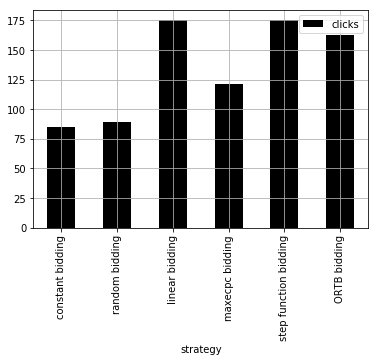

In [40]:
data.plot(kind='bar',color='black',y='clicks',x='strategy',grid=True)